In [1]:
# Imports

import os
import random
import time

import cv2
import numpy as np
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image as DisplayImage

In [2]:
number_of_frames = 2000 # Reduce the number of frames to lessen impact on memory
number_of_tvs = 10000 # Reduce the set of TVs so that it is digestable by UMAP

In [3]:
# Step 1. Grab a random assortment of frames from the movie

np.random.seed(42)

def random_frames_from_video(video_path, num_frames=5):
    """
    Extracts random frames from a video and returns them as a list of NumPy arrays.
    
    Parameters:
        video_path (str): Path to the video file.
        num_frames (int): Number of random frames to extract.
        
    Returns:
        list: NumPy array of NumPy arrays representing the frames.
    """
    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print("Error: Couldn't open the video file.")
        return []

    frames = []

    for _ in tqdm(range(num_frames), desc="Loading in video frames"):
        # Get a random frame number
        frame_num = random.randint(0, total_frames - 1)
        # Set the video position to the frame number
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame
        ret, frame = cap.read()

        if ret:
            frames.append(frame)

    # Release the video capture object
    cap.release()

    # Convert frames to numpy array
    frames = np.array(frames)
    
    return frames

# Extract random frames from the video
frames = random_frames_from_video('cab_ride_trimmed.mkv', num_frames=number_of_frames)
width = frames.shape[1]
height = frames.shape[2]
random_indices = np.random.permutation(width * height) # for shuffling TVs later...

Loading in video frames: 100%|█████████████████████████████████████████████████████| 2000/2000 [03:40<00:00,  9.07it/s]


**TODO**: set this up so that instead of grabbing entire frames, we just grab the TVs so that way we can increase the number of frames we can use


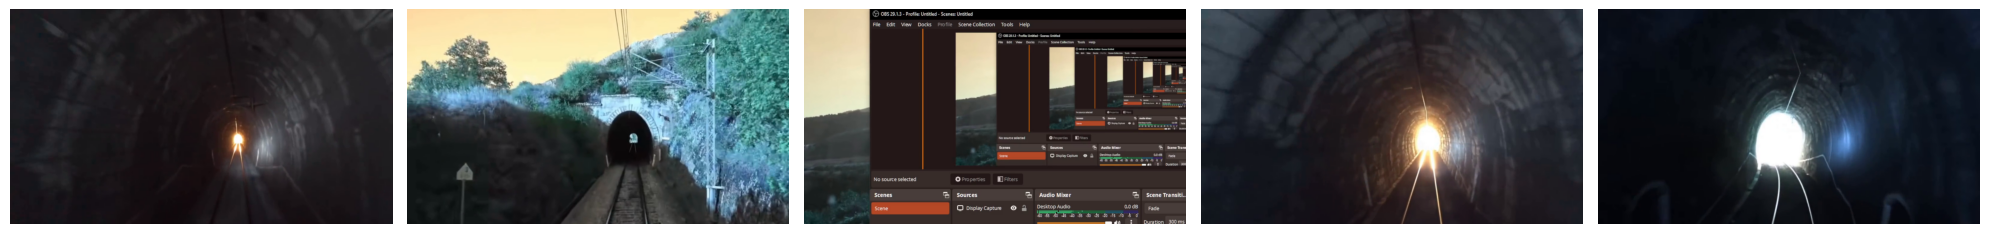

shape: (720, 1280, 3)


In [4]:
# Step 2: Preview a random sample of images

import matplotlib.pyplot as plt

# Display up to 5 frames
display_frames = frames[:5]

fig, axs = plt.subplots(1, len(display_frames), figsize=(20, 5))

for ax, frame in zip(axs, display_frames):
    ax.imshow(frame)
    ax.axis('off')

plt.tight_layout()
plt.show()
print("shape:", frames[0].shape)

In [5]:
# Step 3: Split each pixel position into its respective color series
# (AKA: TVs)

def pixel_color_series(x_position, y_position):
    return frames[:, x_position, y_position]

def tv(position):
    # select a random position so that there aren't any clues about where the TV goes
    position = random_indices[position]

    # convert to an x, y position
    x_position = position % width
    y_position = position // width
    return frames[:, x_position, y_position]

tvs = []
for i in tqdm(range(height * width), desc="Flattening tvs and turning them into a list"):
    tvs.append(tv(i).flatten())

del frames # clear out the frames, because by using flatten() we have created a copy
# note: ravel() might work to return a view instead of making a copy, try this later...

Flattening tvs and turning them into a list: 100%|███████████████████████████| 921600/921600 [03:30<00:00, 4388.37it/s]


<b>TODO:</b> instead of flattening EVERY tv, just flatten the relevant ones to save four minutes...

At this point, we now have each TV stored in the list <b><i>tvs</i></b>.

We should now be applying UMAP to the TVs!

In [9]:
# Step 4: Run UMAP

# Initialize UMAP with desired parameters
reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, n_components=2, metric='euclidean', n_jobs = -1, verbose = True)

# Fit and transform the data
embedding = reducer.fit_transform(tvs[:number_of_tvs])
x_coordinates, y_coordinates = embedding[:, 0], embedding[:, 1]


UMAP(n_neighbors=100, verbose=True)
Wed Sep 25 11:27:13 2024 Construct fuzzy simplicial set
Wed Sep 25 11:27:13 2024 Finding Nearest Neighbors
Wed Sep 25 11:27:13 2024 Building RP forest with 10 trees
Wed Sep 25 11:27:18 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Wed Sep 25 11:28:56 2024 Finished Nearest Neighbor Search
Wed Sep 25 11:28:57 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Sep 25 11:29:14 2024 Finished embedding


In [17]:
# Step 5. Convert the TVs back into a nice "list of colors" format
# instead of a plain old list of values

def list_to_colors(input_list):
    '''
    Parameters:
        input_list: some list of numbers, like [1, 2, 3, 4, 5, 6]

    Returns:
        color_list: the input list chunked in threes, i.e.: [[1, 2, 3], [4, 5, 6]]
    '''
    if len(input_list) % 3 != 0:
        raise ValueError("The length of the list must be a multiple of 3.")
    return [tuple(input_list[i:i + 3]) for i in range(0, len(input_list), 3)]

relevant_tvs = []
for tv in tqdm(tvs[:number_of_tvs], desc = "Converting lists back to colors and normalizing"):
    relevant_tvs.append(list_to_colors(tv))



Converting lists back to colors and normalizing: 100%|██████████████████████████| 10000/10000 [00:31<00:00, 322.02it/s]


Loading animation: 100%|███████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.13it/s]


GIF created and saved as animation.gif


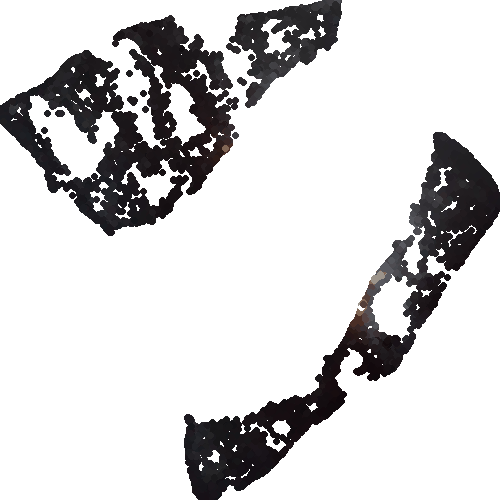

In [21]:
# Step 6. Create the animation

from PIL import Image, ImageDraw
import os
from tqdm import tqdm

def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    return [(x - min_val) / (max_val - min_val) for x in input_list]

def create_color_animation(color_list, x_list, y_list, output_filename='animation.gif', num_frames=None):
    # Set the image size and other parameters
    img_size = (500, 500)
    point_radius = 3  # Adjust point size as needed
    background_color = (255, 255, 255)  # White background
    x_list, y_list = normalize_list(x_list), normalize_list(y_list)
    
    if not num_frames:
        num_frames = len(color_list[0])  # Determine the number of frames from color_list
    
    images = []
    
    # Loop through each frame to generate images
    for frame in tqdm(range(num_frames), desc="Loading animation"):
        # Create a blank image with white background
        img = Image.new('RGB', img_size, background_color)
        draw = ImageDraw.Draw(img)
        
        # Draw each point for the current frame
        for i in range(len(x_list)):
            # Convert x, y to pixel coordinates (scaled to fit the image size)
            x = int(x_list[i] * (img_size[0]))  # Assuming x_list ranges from 0 to 1
            y = int(y_list[i] * (img_size[1]))  # Assuming y_list ranges from 0 to 1
            
            # Get the color for the current frame
            color = tuple(map(int, color_list[i][frame]))  # Convert to RGB tuple
            
            # Draw the point as a circle
            draw.ellipse([x - point_radius, y - point_radius, x + point_radius, y + point_radius], fill=color)
        
        # Append the frame to the list of images
        images.append(img)
    
    # Create a GIF from the list of images
    images[0].save(output_filename, save_all=True, append_images=images[1:], duration=300, loop=0)
    
    print(f"GIF created and saved as {output_filename}")

# Call the function to create the GIF
create_color_animation(relevant_tvs, x_coordinates, y_coordinates, num_frames=10)

# Display the GIF
DisplayImage(filename='animation.gif')


The UMAP reconstruction is pretty stringy and clearly needs some work...